# Multi-pendulums
Created by: Wesley Terrill (04/03/2019)

Revision Dates: 

(04/04/2019): began program
               
(04/04/2019): implemented sympy for positions <br/>
implemented class multi_pendulum with functions Lagrangian, Lagrange

(04/05/2019): debugging Lagrange for correct diffeq output

(04/10/2019): altered when constants take on non-symbolic values

(04/11/2019): debugging substitute loop <br/>
adjusted the conversion function <br/>
began function Solve_ODE

(04/12/2019): adjusted substitute function to sub in $\dot\phi_1$ and $\dot\phi_2$ into each others equations of motion<br/>
fixed ODE output for correct equations of motion<br/>
added function for right side of differential equations

(04/15/2019): finished Solve_ODE broken

(04/17/2019): hand type diff_eq of double pendulum <br/>
Solves correctly and quickly

Creates a system to solve double and triple pendulum problem as a 
class. Basic output as plots of the two angles as a function of time.
Show chaos for angles above small angle conditions.


In [1]:
%matplotlib notebook

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy import linalg as LA 

from scipy.integrate import odeint

from mpmath import *

#import functions from sympy
import sympy as sym
from sympy import *
#from sympy.mpmath import *

#from sympy.functions.elementary.trigonometric import sin, cos
from sympy.physics.vector import dynamicsymbols
from sympy import diff, Symbol
from sympy.printing.mathml import print_mathml
from sympy.abc import t
from sympy.utilities.lambdify import lambdify, implemented_function
from sympy import Function

from IPython.display import display, Math #for printing latex string

from scipy.integrate import solve_ivp

from matplotlib import animation, rc
from IPython.display import HTML, Image
from matplotlib import animation, rc


Find the expressions for position, velocity, and acceleration in 
terms of variables that specify the state of the device.

$\begin{align}
    x = horizontal \; position \; of \; pendulum \; mass   
\\
    y = vertical \; position \; of \; pendulum \; mass    
\\
    \theta = angle \; of \; pendulum \; (0 \; is \; vertically \;   
    downwards, \;
    counter-clockwise \; is \; positive)
\\
    L = length \; of  \; rod \; (constant)
\end{align}$   


Place the origin at the pivot of the upper pendulum. Take y increasing as upwards. Indicate upper pendulum by subscript 1, and lower by subscript 2. Begin by using simple geometry to write 
$x_1, \; y_1,\;x_2,\;y_2$ in terms of the angles $\theta_1,\; \theta_2$. 

Note: written below for double pendulum only. Code adjusted to symbollically solve.

In [3]:
display(Image(url='https://www.myphysicslab.com/pendulum/dbl_pendulum.gif'))

$\begin{align}
  x_1 = L_1 \sin(\theta_1)
\\
  y_1 = -L_1 \cos(\theta_1)
\\
  x_2 = x_1 + L_2 \sin(\theta_2)
\\
  y_2 = y_1 - L_2 \cos(\theta_2)
\end{align}$

The velocity is the derivative with respect to time.

$
  \dot{x_1} = L_1 \dot{\theta_1} \cos(\theta_1)
  $
  
  $
  \dot{y_1} = L_1 \dot{\theta_1} \sin(\theta_1)
  $
  
  $
  \dot{x_2} = \dot{x_1} + L_2 \dot{\theta_2} \cos(\theta_2)
  $
  
  $
  \dot{y_2} = \dot{y_1} + L_2 \dot{\theta_2} \sin(\theta_2)
$

First, set up a list of symbols capable of performing requested tasks.

In [4]:
# define dynamic symbols (the angles for any number of masses attached)
theta_1, theta_2, theta_3 = dynamicsymbols('theta_1, theta_2, theta_3')

# define dynamic symbols for substitution later
phi_1, phi_2, phi_3 = symbols('phi_1, phi_2, phi_3')

#create derivative of the angles
theta_1_dot = diff(theta_1, t)
theta_2_dot = diff(theta_2, t)
theta_3_dot = diff(theta_3, t)

#create derivative of the sub terms
phi_1_dot = symbols(r'\dot{\phi_1}')
phi_2_dot = symbols(r'\dot{\phi_2}')
phi_3_dot = diff(phi_3, t)


### define constants ###
#gravity
g = symbols('g', integer=True, positive=True)

#lengths
L1 = symbols('L_1', integer=True, positive=True)
L2 = symbols('L_2', integer=True, positive=True)
L3 = symbols('L_3', integer=True, positive=True)

#masses
m1 = symbols('m_1', integer=True, positive=True)
m2 = symbols('m_2', integer=True, positive=True)
m3 = symbols('m_3', integer=True, positive=True)



Next, create the symbolic equations of the cartesian form in terms of the polar terms.

In [5]:
### define cartesian in terms of theta ###
# first mass at top pendulum
x1 = L1 * sin(theta_1)
y1 = -L1 * cos(theta_1)

# second mass
x2 = x1 + L2 * sin(theta_2)
y2 = y1 - L2 * cos(theta_2)

#third mass
x3 = x2 + L3 * sin(theta_3)
y3 = y2 - L3 * cos(theta_3)

### define cartesian velocities ###
#first mass
x1_dot = diff(x1, t)
y1_dot = diff(y1, t)

#second mass
x2_dot = diff(x2, t)
y2_dot = diff(y2, t)

#third mass
x3_dot = diff(x3, t)
y3_dot = diff(y3, t)

#debugging line, sub in variable for displayig test
#display(Math(latex(y3_dot)))

In [6]:
class multi_pendulum():
    """
    multi_pendulum class implements the parameters to solve 
    Lagrangian for motion of system of multiple pendulums
    
    Parameters
    ----------
    q(t) : dynamic symbol array
        position of mass as a function of time in terms of angle
        to be solved for
        will be defined outside class
        
    q_dot(t) : dynamic symbol array
        angular velocity of mass as a function of time
        defined outside class
    
    Methods
    -------
    Lagrangian
        creates lagrangian given kinetic energy and potential energy
        in terms of q(t) and q_dot(t)
        Returns the Lagrangian
        
    Lagrange
        takes Lagrangian and uses to solve the Lagrange equations
        Returns two lists of each half of differential equations
    """
    
    def __init__(self, q, q_dot, p, p_dot):
        self.q = q
        self.q_dot = q_dot
        self.p = p
        self.p_dot = p_dot
        
    def Lagrangian(self, U, T):
        """
        Forms the Lagrangian of the pendulum system given Potential 
        and Kinetic energy of system
        Solves Lagranges equations symbolically
        Returns the Lagrange
        """
        
        self.Lagrangian = simplify(T - U)
        
        return self.Lagrangian
    
    def Lagrange(self):
        """
        takes Lagrangian and uses to solve the Lagrange equations
        Returns two lists of each half of differential equations
        """
        # intialize list of ODE for each term
        self.ODE = []
        
        # iterates for each angle variable
        for i in range(0, len(self.q)):
            #Derivative with respect to q
            dL_dq = diff(self.Lagrangian, self.q[i])
        
            #Derivative with respect to q_dot
            dL_dq_dot = simplify(diff(self.Lagrangian, self.q_dot[i]))
        
            #Time derivative
            dL_dq_dot_dt = diff(dL_dq_dot, t)
            
            #assemble as function
            lagrange = simplify(Eq(dL_dq,dL_dq_dot_dt))
        
            #loop substitutes variables earlier for ease of reading using vector U
            for j in range(len(self.q)):
                lagrange = lagrange.subs([(diff(self.q_dot[j],t), self.p_dot[j]), (self.q_dot[j], self.p[j]), \
                                           (self.q[j],rf'theta_{j+1}')])
            
            diffeq = solve(lagrange, self.p_dot[i])
            #self.ODE.append([diff(diff(self.q[i],t),t), diffeq])
            self.ODE.append(diffeq)
    
        return simplify(self.ODE)

In [7]:
class double_pendulum(multi_pendulum):
    """
    double_pendulum is a subClass of multipendulum optimized for the 
    double pendulum problem
    
    Parameters
    ----------
    q(t) : dynamic symbol array
        position of mass as a function of time in terms of angle
        to be solved for
        will be defined outside class
        
    q_dot(t) : dynamic symbol array
        angular velocity of mass as a function of time
        defined outside class
        
    p(t) : dynamic symbol array
        equivalent substituent of q_dot(t)
        defined outside class
    
    p_dot(t) : dynamic symbol array
        equivalent substituent to second derivative of q(t)
        with respect to time
        
    L_i : numeric value
        numeric length of pendulum i 
        
    m_i : numeric value
        numeric mass of pendulum i
        
    grav : numeric value
        gravitational acceleration
        
    Methods
    -------
    substitute
        substitutes in the numeric variables for length, mass, and
        gravitational acceleration into the equations of motion.
        Also substitutes the dynamic variables for normal constant
        values.
        
    conversion
        converts the numerically substituted variables to numpy usable
        functions using lambdify.
    """
    def __init__(self, q, q_dot, p, p_dot, theta, phi, \
                 L_1=1., L_2=1., m_1=1., m_2=1., grav=1.):
        multi_pendulum.__init__(self, q, q_dot, p, p_dot)
        self.L_1 = L_1
        self.L_2 = L_2
        self.m_1 = m_1
        self.m_2 = m_2
        self.grav = grav
        
        self.p = p
        self.p_dot = p_dot
        
        self.theta = theta
        self.phi = phi
    
    def substitute(self):
        """
        substitute substitutes numerical values in for constants related to symbolic expressions 
        of the differential equations
        """
        ODE = self.Lagrange()
        y=[ODE[0][0],ODE[1][0]]
        
        z = []
        subbed=[]
        for i in range(len(self.q)):
            sub = y[i-1]
            
            #substitute second equation into first for phi_dot_second
            subbing = y[i].subs(self.p_dot[i-1], sub)
            
            #re-solve for phi_dot_first
            solved = solve(Eq(subbing, self.p_dot[i]), self.p_dot[i])
            
            subbed.append(solved)
            #x = solve(subbed, self.p_dot[i])
            #w = simplify(x[self.p_dot[i]])
            #z.append(w)
        
        return subbed
    
    # following function used for future updates
    def conversion(self): 
        """
        converts input to a lambdify generated function
        """
        # call substituted equations of motion
        numODE = self.substitute()
        
        # initialize empty array of the converted function
        self.npfunc = []
        
        # loop through the equations of motion
        for i in range(len(numODE)):
            f = lambdify((self.theta[0], self.theta[1], self.phi[0], self.phi[1],\
                         'L_1', 'L_2', 'm_1', 'm_2', 'g'), numODE[i][0], np)
            self.npfunc.append(f)
            
        return self.npfunc
    
    # Define a function for the right side
    def dU_dx_old(self, t, U):
        """
        Right side of the differential equation to be solved.
        U is a four-component vector with theta_1=U[0], phi_1=U[1],
        theta_2=U[2], phi_2=U[3]. 
        Thus this function should return [phi_1, phi_1', phi_2, phi_2']
        Uses direct copy of code from phi_1' and phi_2' in place of 
        lambdify generated functions
        """
        #self.npfunc = self.conversion()
        
        # create the first diff eq from lambdify generated equations
        phi_1_dot = self.npfunc[0](U[0],U[2],U[1],U[3], self.L_1, self.L_2, self.m_1, self.m_2, self.grav)
        
        # created the second diff eq from lambdify generated equations
        phi_2_dot = self.npfunc[1](U[0],U[2],U[1],U[3], self.L_1, self.L_2, self.m_1, self.m_2, self.grav)
        
        return [U[1], phi_1_dot, U[3], phi_2_dot] 
    
    def Solve_ODE_old(self, t_pts, theta_01, phi_01, theta_02, phi_02):
        """
        solves the equations of motion using solve_ivp.
        Bring in array of time points, initial angles,
        and angular velocities.
        """
        U_0 = [theta_01, phi_01, theta_02, phi_02]
        solution = solve_ivp(self.dU_dx_old, (t_pts[0], t_pts[-1]),\
                             U_0, t_eval = t_pts, method='RK23',\
                             atol = 1.0e-5, rtol = 1.0e-5)
        
        theta_1, phi_1, theta_2, phi_2 = solution.y
        print(solution.message, solution.success)
        return theta_1, phi_1, theta_2, phi_2

The program finds the Lagrange equation and displays it after setting up 
coordinates correctly within the energy terms.

In [8]:
#Create lists of variables that are substituted
theta1 = symbols('theta_1')
theta2 = symbols('theta_2')

theta = [theta1, theta2]
phi = [phi_1, phi_2]
phi_dot = [phi_1_dot, phi_2_dot]

### double pendulum energy ###
# potential
U = m1 * g * y1 + m2 * g * y2

# Kinetic
T = simplify(m1/2 * (x1_dot**2 + y1_dot**2) + m2/2 * (x2_dot**2 + y2_dot**2))

### initialize multi_pendulum class ###
# create lists of required variables
theta_t = [theta_1, theta_2]
theta_dot = [theta_1_dot, theta_2_dot]
phi_t = [phi_1, phi_2]
phi_dot_t = [phi_1_dot, phi_2_dot]

# initialize class
double_pen = double_pendulum(q = theta_t, q_dot = theta_dot, p = phi_t, \
                             p_dot = phi_dot_t, theta = theta, phi = phi,\
                             L_1 = 1., L_2 = 1., m_1 = 1., m_2 = .1)

lag = double_pen.Lagrangian(U = U, T = T)

#view lagrange
display(Math(latex(lag)))

<IPython.core.display.Math object>

A change of variables is made such that the angular velocity for each term is represented by the relation: <br/>
$\dot{\theta_i} = \phi_i$ <br/>
The differential equations presented with each equal to $\dot{\phi_i}$ in the vector by the solving lagranges equations are:

In [9]:
# solve lagrange equations
diffeq = double_pen.Lagrange()
display(Math(latex((diffeq))))

<IPython.core.display.Math object>

Set up 4 first order equations introducing new values $\phi_1, \phi_2$ such that

$\phi_1 = \dot{\theta_1} \\
\phi_2 = \dot{\theta_2} $

For Double pendulum based, the original differential equation is given by: <br/>
$
\ddot{\theta_1} = -\frac{L_2 m_2 \sin(\theta_1-\theta_2) \dot{\theta_2}^2
+ L_2 m_2 \cos(\theta_1-\theta_2) \ddot{\theta_2} + g m_1 \sin(\theta_1) + g m_2 \sin(\theta_1)}
{L_1 (m_1 + m_2)}
\\
\ddot{\theta_2} = \frac{L_1 \sin(\theta_1-\theta_2) \dot{\theta_1}^2 - L_1 \cos(\theta_1-\theta_2) \ddot{\theta_1}
- g \sin(\theta_2)}
{L_2}
$

The four linear first order equations are now:<br/>
$\phi_1 = \dot{\theta_1}
\\
\dot{\phi_1} = -\frac{L_2 m_2 \sin(\theta_1-\theta_2) \phi_2^2
+ L_2 m_2 \cos(\theta_1-\theta_2) \dot{\phi_2} + g m_1 \sin(\theta_1) + g m_2 \sin(\theta_1)}
{L_1 (m_1 + m_2)}
\\
\phi_2 = \dot{\theta_2}
\\
\dot{\phi_2} = \frac{L_1 \sin(\theta_1-\theta_2) \phi_1^2 - L_1 \cos(\theta_1-\theta_2) \dot{\phi_2}
- g \sin(\theta_2)}
{L_2}
$


The substituted differential equations are displayed below to remove dependence on the $\dot{\phi_i}$ between the equations.

The double_pen.conversion line is slow but is necessary to convert the sympy components of the differential equations to format necessary for the differential equation solver.

In [10]:
numODE = double_pen.substitute()
display(Math(latex(simplify(numODE))))
numODE
 
#call the conversion function to speed up solver. Creates the lambdify generated function sooner.     
double_pen.conversion();

<IPython.core.display.Math object>

Set up the array of time points

In [11]:
#the time points
t_start = 0.
t_stop = 40.
delta_t = .01
t_pts = np.arange(t_start, t_stop + delta_t, delta_t)

Now the differential equation is ready to be solved numerically. Setting initial conditions for the angles and the angular velocity terms.

In [12]:
# Set initial conditions (angles in radians)
theta_01 = 0*np.pi/12.
theta_02 = np.pi/12.
phi_01 = 0.
phi_02 = 0.

theta1, phi1, theta2, phi2 = double_pen.Solve_ODE_old(t_pts = t_pts, \
                                                  theta_01 = theta_01, \
                                                  phi_01 = phi_01, \
                                                  theta_02 = theta_02, \
                                                  phi_02 = phi_02)   
    
#print(len(t_pts))
#print(len(theta1))

The solver successfully reached the end of the integration interval. True


In [13]:
def plot(angles, velocity, t_pts, colors):
    """
    creates plots of angles versus time and phase-space plots
    """
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(2,1,1)
    ax2 = fig.add_subplot(2,1,2)
    
    for i in range(len(angles)):
        ax.plot(t_pts, angles[i], linestyle='dashed', color=colors[i],\
                label=rf'$\theta_{i}$')
        
        ax2.plot(angles[i], velocity[i], linestyle='dashed', color=colors[i],\
                label=rf'$\theta_{i}$')
        
    
    ax.legend()

    #ax.set_xlim(0., t_stop)
    #ax.set_ylim(-np.pi, np.pi)
    ax.set_xlabel('t')
    ax.set_ylabel(rf'$\theta(t)$')
    
    ax2.legend()

    #ax.set_xlim(0., t_stop)
    #ax.set_ylim(-np.pi, np.pi)
    ax2.set_ylabel(r'$\dot{\theta}(t)$')
    ax2.set_xlabel(rf'$\theta(t)$')
    
    fig.tight_layout()


<IPython.core.display.Javascript object>


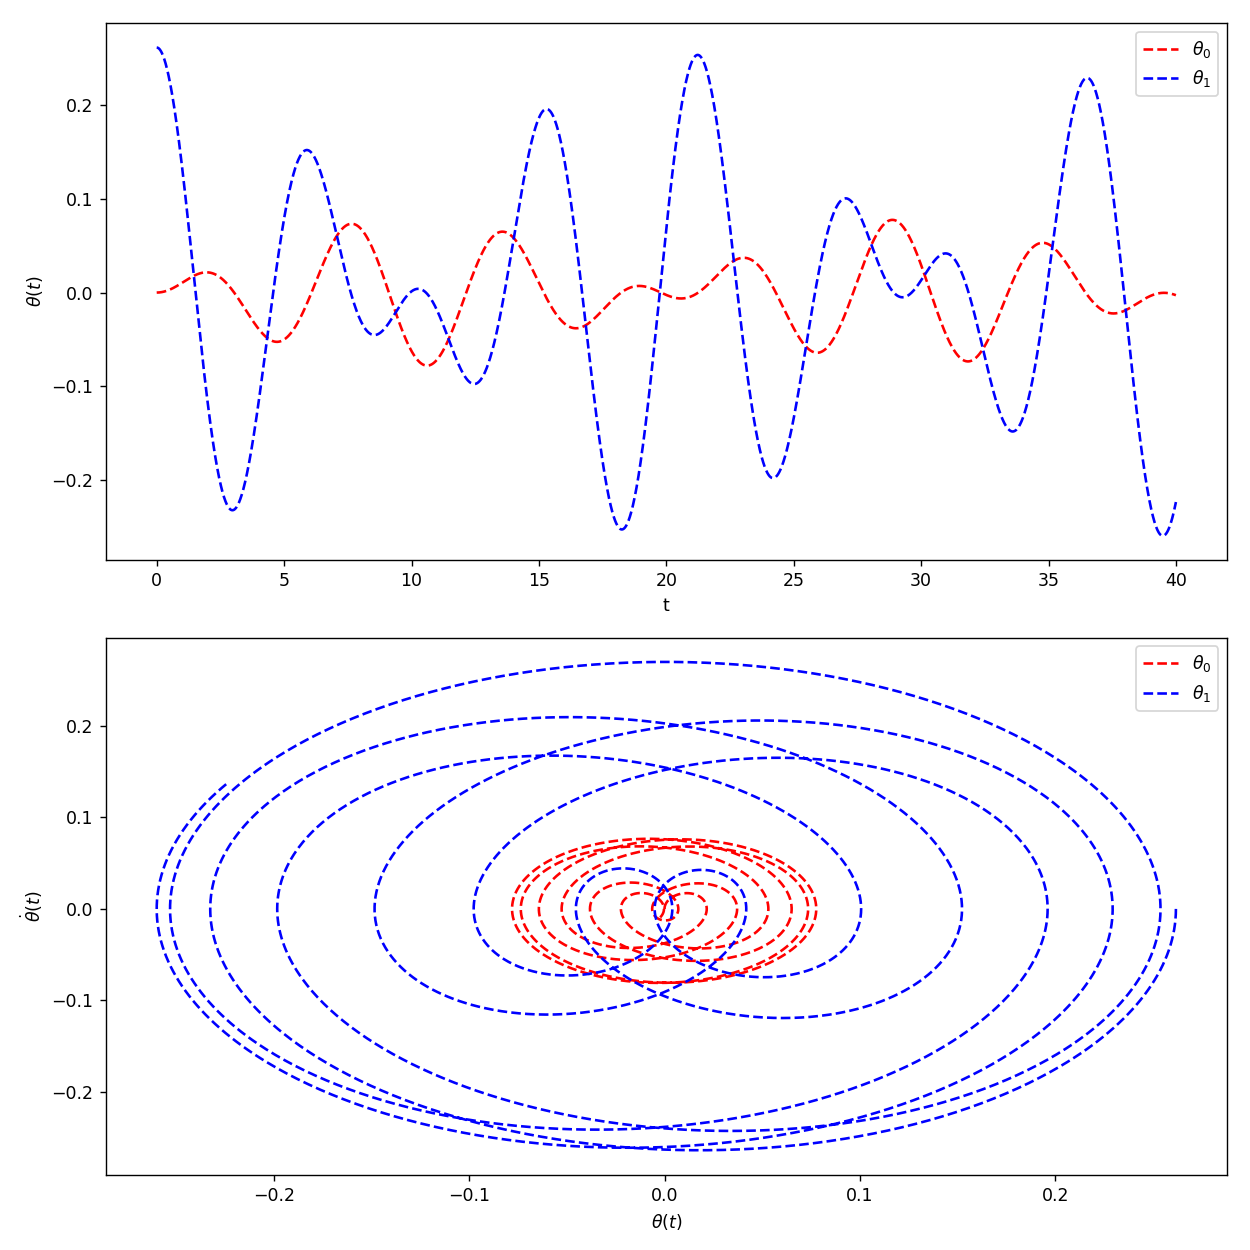

In [14]:
angles = [theta1, theta2]
velocity = [phi1, phi2]
colors = ['red', 'blue']
plot(angles = angles, velocity = velocity, t_pts = t_pts, colors = colors)

In [15]:
t_start = 0.
t_stop = 40.
delta_t = .01
t_pts = np.arange(t_start, t_stop + delta_t, delta_t)

In [16]:
%%capture
        
fig_anim = plt.figure(figsize=(6,2), num = 'pendulum')
ax_anim = fig_anim.add_subplot(1,1,1)
ax_anim.set_xlabel('t')
ax_anim.set_ylabel(rf'$\theta$')
ax_anim.set_xlim(t_start, t_stop)

line_anim, = ax_anim.plot(t_pts[0], theta1[0], color = 'blue', lw=2)
        
fig_anim.tight_layout()
        

In [17]:
def animate_pendulum(i):
    """
    This is the function called by FuncAnimation to create each frame,
    numbered by i.  So each i corresponds to a point in the t_pts
    array, with index i.
    """
    t = t_pts[i]
    y_pts = theta1[i]
        
    line_anim.set_data(t_pts, y_pts)
        
    return(line_anim,)

In [18]:
frame_interval = 40.  # time between frames
frame_number = int(np.abs(t_start-t_stop)/delta_t)    # number of frames to include (index of t_pts)
anim = animation.FuncAnimation(fig_anim, 
                               animate_pendulum, 
                               init_func=None,
                               frames=frame_number, 
                               interval=frame_interval, 
                               blit=False,
                               repeat=False)

In [ ]:
HTML(anim.to_jshtml())


In [ ]:
def start_stop_indices(t_pts, plot_start, plot_stop):
    """Given an array (e.g., of times) and desired starting and stop values,
        return the array indices that are closest to those values.
    """
    start_index = (np.fabs(t_pts-plot_start)).argmin()  # index in t_pts array 
    stop_index = (np.fabs(t_pts-plot_stop)).argmin()  # index in t_pts array 
    return start_index, stop_index